# Notebook 04a — Datasets progressifs UC1

**Objectif** : Créer 4 datasets de complexité croissante pour le use case "Priorisation des Secours", simulant les niveaux d'information disponibles lors d'un appel d'urgence.

**Input** : `dataset_features_intelligentes.csv`
**Output** : `UC1_v1_base.csv`, `UC1_v2_route.csv`, `UC1_v3_vehicules.csv`, `UC1_v4_collision.csv`
**Notebook suivant** : `05a_model_UC1_secours.ipynb`

### Les 4 niveaux d'information

Lors d'un appel au 15/18, les informations arrivent progressivement :

| Version | Scénario | Features | Nb features |
|---------|----------|----------|-------------|
| V1 — Base | "Accident à 3h du matin dans le 75" | dep, heure, mois, weekend, nuit... | 8 |
| V2 — Route | "Sur une départementale, 90 km/h, hors agglo" | + vma, type_route, hors_agglo... | 22 |
| V3 — Véhicules | "Implique une moto et un poids lourd" | + has_moto, has_vehicule_lourd... | 30 |
| V4 — Collision | "Collision frontale" | + collision_frontale, collision_solo... | 34 |

Chaque version contient toutes les features des versions précédentes.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuration Plotly
import plotly.io as pio
pio.templates.default = "plotly_white"
pio.renderers.default = "png"

# Charger le dataset avec features intelligentes (v2)
df = pd.read_csv('../../../data/dataset_features_intelligentes.csv')
print(f"Dataset chargé: {df.shape}")
print(f"\nColonnes disponibles ({len(df.columns)}):")
print(list(df.columns))

Dataset chargé: (208616, 46)

Colonnes disponibles (46):
['Num_Acc', 'annee', 'dep', 'vma', 'nbv', 'heure', 'mois', 'age_moyen', 'nb_usagers', 'nb_vehicules', 'nb_pietons', 'nb_hommes', 'nb_femmes', 'weekend', 'heure_pointe', 'nuit', 'hors_agglo', 'nuit_eclairee', 'bidirectionnelle', 'haute_vitesse', 'meteo_degradee', 'surface_glissante', 'intersection_complexe', 'route_en_pente', 'route_autoroute', 'route_departementale', 'route_communale', 'collision_frontale', 'collision_arriere', 'collision_cote', 'collision_solo', 'obstacle_arbre', 'obstacle_fixe_dur', 'obstacle_pieton', 'has_moto', 'has_velo', 'has_edp', 'has_cyclomoteur', 'has_pieton', 'has_vehicule_lourd', 'collision_asymetrique', 'heure_danger', 'weekend_nuit', 'nuit_hors_agglo', 'mortel', 'grave']


In [2]:
# Vérification de la target
print("TARGET UC1 : GRAVE (blessures graves)\n")

print("--- Comparaison MORTEL vs GRAVE ---")
for col in ['mortel', 'grave']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    ratio = (1 - df[col].mean()) / df[col].mean()
    print(f"{col.upper():>8}: {n} cas ({pct:.1f}%) - Ratio 1:{ratio:.1f}")

print("\n--- Choix justifié : GRAVE ---")
print("Intervention peut sauver des vies (vs trop tard pour mortel)")
print("Ratio 1:1.8 (vs 1:16.6) - modèle plus stable")
print("73796 cas positifs (vs 11843) - meilleur apprentissage")
print("100% des mortels sont inclus dans grave")

TARGET UC1 : GRAVE (blessures graves)

--- Comparaison MORTEL vs GRAVE ---
  MORTEL: 11843 cas (5.7%) - Ratio 1:16.6
   GRAVE: 73796 cas (35.4%) - Ratio 1:1.8

--- Choix justifié : GRAVE ---
Intervention peut sauver des vies (vs trop tard pour mortel)
Ratio 1:1.8 (vs 1:16.6) - modèle plus stable
73796 cas positifs (vs 11843) - meilleur apprentissage
100% des mortels sont inclus dans grave


---
## 1. Définition des groupes de features

Features classées par disponibilité en temps réel lors de l'appel d'urgence.

### Principe de progression

| Version | Scénario | Information disponible |
|---------|----------|------------------------|
| V1 | Appel minimal | GPS + heure (automatique) |
| V2 | Route identifiée | + type de route via GPS/carte |
| V3 | Véhicules décrits | + "Il y a un camion et une moto" |
| V4 | Collision décrite | + "Ils se sont percutés de face" |

In [3]:
# Métadata (conservées pour split temporel, pas utilisées comme features)
meta_cols = ['Num_Acc', 'annee']

# Niveau 1 : Toujours disponible (département + temporel)
features_v1 = [
    # département (géocodage GPS)
    'dep',
    # temporel
    'heure', 'mois',
    'weekend', 'nuit', 'heure_pointe', 'heure_danger',
    'nuit_eclairee',
]

# Niveau 2 : Disponible si route identifiée (GPS/carte)
features_v2 = features_v1 + [
    # route
    'vma', 'nbv',
    'hors_agglo', 'bidirectionnelle', 'haute_vitesse',
    # météo et surface
    'meteo_degradee', 'surface_glissante', 'intersection_complexe', 'route_en_pente',
    # type de route
    'route_autoroute', 'route_departementale', 'route_communale',
    'nuit_hors_agglo', 'weekend_nuit',
]

# Niveau 3 : Info véhicules (décrit par l'appelant)
features_v3 = features_v2 + [
    # véhicules
    'has_moto', 'has_velo', 'has_edp', 'has_cyclomoteur', 'has_pieton',
    'has_vehicule_lourd',
    'collision_asymetrique',
    'nb_vehicules',
]

# Niveau 4 : Info collision (si l'appelant décrit la scène)
features_v4 = features_v3 + [
    'collision_frontale',   # Choc frontal
    'collision_arriere',    # Carambolage
    'collision_cote',       # Collision latérale
    'collision_solo',       # Sortie de route
]

# Features exclues (post-accident ou redondantes)
features_exclues = [
    # Post-accident
    'obstacle_arbre', 'obstacle_fixe_dur', 'obstacle_pieton',
    'nb_usagers', 'nb_passagers', 'nb_pietons',
    'nb_hommes', 'nb_femmes', 'age_moyen',
    # pas dans le dataset 03a
    'lat', 'long',
    # redondants ou non pertinents
    'nuit_non_eclairee', 'has_vulnerable', 'has_poids_lourd', 'has_bus',
    'jour_semaine', 'route_nationale', 'route_rapide',
]

# Target : GRAVE
target = 'grave'

print("Groupes de features définis (v2):")
print(f"  V1 (département + temporel)      : {len(features_v1)} features")
print(f"  V2 (+ route + météo/surface)     : {len(features_v2)} features")
print(f"  V3 (+ véhicules décrits)         : {len(features_v3)} features")
print(f"  V4 (+ type collision)            : {len(features_v4)} features")
print(f"\nMétadata (pour split temporel): {meta_cols}")
print(f"Features exclues (post-accident/redondantes): {len(features_exclues)}")
print(f"Target: {target.upper()}")

Groupes de features définis (v2):
  V1 (département + temporel)      : 8 features
  V2 (+ route + météo/surface)     : 22 features
  V3 (+ véhicules décrits)         : 30 features
  V4 (+ type collision)            : 34 features

Métadonnées (pour split temporel): ['Num_Acc', 'annee']
Features exclues (post-accident/redondantes): 18
Target: GRAVE


In [4]:
# Vérifier que toutes les features existent dans le dataset
print("Vérification des features:\n")

all_features = set(features_v4)
missing = [f for f in all_features if f not in df.columns]

if missing:
    print(f"Features manquantes: {missing}")
else:
    print("Toutes les features sont présentes dans le dataset.")

# Afficher les features par niveau
print("\nDétail par niveau:")
print(f"V1: {features_v1}")
print(f"\nV2 ajout: {[f for f in features_v2 if f not in features_v1]}")
print(f"\nV3 ajout: {[f for f in features_v3 if f not in features_v2]}")
print(f"\nV4 ajout: {[f for f in features_v4 if f not in features_v3]}")

Vérification des features:

Toutes les features sont présentes dans le dataset.

Détail par niveau:
V1: ['dep', 'heure', 'mois', 'weekend', 'nuit', 'heure_pointe', 'heure_danger', 'nuit_eclairee']

V2 ajout: ['vma', 'nbv', 'hors_agglo', 'bidirectionnelle', 'haute_vitesse', 'meteo_degradee', 'surface_glissante', 'intersection_complexe', 'route_en_pente', 'route_autoroute', 'route_departementale', 'route_communale', 'nuit_hors_agglo', 'weekend_nuit']

V3 ajout: ['has_moto', 'has_velo', 'has_edp', 'has_cyclomoteur', 'has_pieton', 'has_vehicule_lourd', 'collision_asymetrique', 'nb_vehicules']

V4 ajout: ['collision_frontale', 'collision_arriere', 'collision_cote', 'collision_solo']


---
## 2. Création des datasets

In [5]:
# Définir les versions
datasets = {
    'v1_base': features_v1,
    'v2_route': features_v2,
    'v3_vehicules': features_v3,
    'v4_collision': features_v4,
}

print("CRÉATION DES DATASETS UC1 (v2)\n")

created_datasets = {}

for name, features in datasets.items():
    # Créer le dataset avec métadata (annee pour split temporel)
    cols_to_include = meta_cols + features + [target]
    
    # Vérifier que toutes les colonnes existent
    missing = [c for c in cols_to_include if c not in df.columns]
    if missing:
        print(f"{name}: Colonnes manquantes: {missing}")
        continue
    
    df_version = df[cols_to_include].copy()
    
    # Sauvegarder
    filename = f'../../../data/UC1_{name}.csv'
    df_version.to_csv(filename, index=False)
    
    # Stocker pour analyse
    created_datasets[name] = df_version
    
    # Stats
    n_grave = df_version[target].sum()
    pct_grave = df_version[target].mean() * 100
    
    # Stats split temporel
    n_train = len(df_version[df_version['annee'] <= 2023])
    n_test = len(df_version[df_version['annee'] == 2024])
    
    print(f"{name}:")
    print(f"  Shape: {df_version.shape}")
    print(f"  Features: {len(features)} (+2 meta +1 target)")
    print(f"  Target GRAVE: {n_grave} ({pct_grave:.1f}%)")
    print(f"  Split temporel: Train {n_train} (2021-2023) / Test {n_test} (2024)")
    print(f"  Fichier: data/UC1_{name}.csv\n")

CRÉATION DES DATASETS UC1 (v2)

v1_base:
  Shape: (208616, 11)
  Features: 8 (+2 meta +1 target)
  Target GRAVE: 73796 (35.4%)
  Split temporel: Train 157561 (2021-2023) / Test 51055 (2024)
  Fichier: data/UC1_v1_base.csv

v2_route:
  Shape: (208616, 25)
  Features: 22 (+2 meta +1 target)
  Target GRAVE: 73796 (35.4%)
  Split temporel: Train 157561 (2021-2023) / Test 51055 (2024)
  Fichier: data/UC1_v2_route.csv

v3_vehicules:
  Shape: (208616, 33)
  Features: 30 (+2 meta +1 target)
  Target GRAVE: 73796 (35.4%)
  Split temporel: Train 157561 (2021-2023) / Test 51055 (2024)
  Fichier: data/UC1_v3_vehicules.csv

v4_collision:
  Shape: (208616, 37)
  Features: 34 (+2 meta +1 target)
  Target GRAVE: 73796 (35.4%)
  Split temporel: Train 157561 (2021-2023) / Test 51055 (2024)
  Fichier: data/UC1_v4_collision.csv



### Observation : Création des datasets

Cohérence vérifiée :
- Tous les datasets ont exactement 208,616 lignes (nombre d'accidents)
- Tous ont 73,796 accidents graves (35.4%) - target identique
- Progression logique : 8 → 22 → 30 → 34 features

Fichiers créés : UC1_v1_base.csv, UC1_v2_route.csv, UC1_v3_vehicules.csv, UC1_v4_collision.csv

---
## 3. Analyse des corrélations par version

In [6]:
print("TOP 10 CORRÉLATIONS AVEC GRAVE PAR VERSION\n")

all_correlations = {}

for name, features in datasets.items():
    print(f"--- {name.upper()} ({len(features)} features) ---")
    correlations = []
    for feat in features:
        # dep est catégoriel (string), pas de corrélation Pearson
        if df[feat].dtype == 'object':
            continue
        corr = df[feat].corr(df[target])
        correlations.append((feat, corr))
    
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    all_correlations[name] = correlations
    
    for i, (feat, corr) in enumerate(correlations[:10], 1):
        print(f"  {i:>2}. {feat}: {corr:+.3f}")
    print()

TOP 10 CORRÉLATIONS AVEC GRAVE PAR VERSION

--- V1_BASE (8 features) ---
   1. nuit_eclairee: -0.087
   2. weekend: +0.075
   3. heure_danger: +0.042
   4. heure_pointe: -0.037
   5. heure: -0.015
   6. nuit: +0.015
   7. mois: +0.010

--- V2_ROUTE (22 features) ---
   1. route_departementale: +0.259
   2. hors_agglo: +0.257
   3. route_communale: -0.208
   4. bidirectionnelle: +0.203
   5. vma: +0.201
   6. nuit_hors_agglo: +0.118
   7. nbv: -0.106
   8. intersection_complexe: -0.103
   9. route_en_pente: +0.096
  10. nuit_eclairee: -0.087

--- V3_VEHICULES (30 features) ---
   1. route_departementale: +0.259
   2. hors_agglo: +0.257
   3. route_communale: -0.208
   4. bidirectionnelle: +0.203
   5. vma: +0.201
   6. nb_vehicules: -0.129
   7. nuit_hors_agglo: +0.118
   8. nbv: -0.106
   9. intersection_complexe: -0.103
  10. route_en_pente: +0.096

--- V4_COLLISION (34 features) ---
   1. route_departementale: +0.259
   2. hors_agglo: +0.257
   3. route_communale: -0.208
   4. bidire

### Observation : Corrélations par version

V1 (temporel seul) : corrélation max = 0.087 (nuit_eclairee). Le temporel seul a un pouvoir prédictif limité.

V2 (+ route) : le saut est massif. route_departementale (+0.259) et hors_agglo (+0.257) dominent largement. L'identification de la route est l'information la plus discriminante pour prédire la gravité.

V3 et V4 : les top features restent les mêmes (route), les ajouts véhicules et collision enrichissent le modèle mais ne changent pas le top du classement.

Implication opérationnelle : La question prioritaire aux secours est "Où êtes-vous ?" (ville vs route).

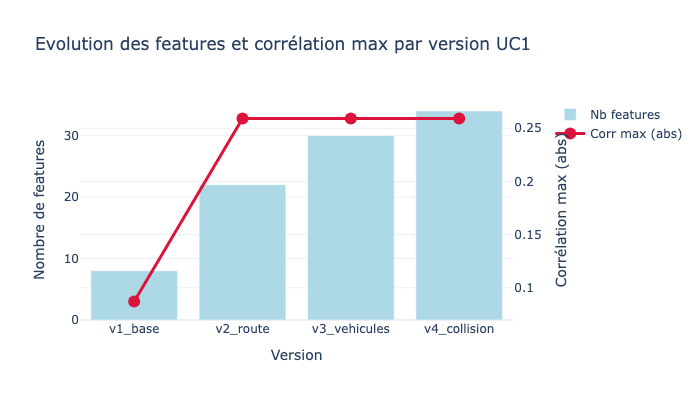

In [7]:
# Visualisation : Evolution des corrélations max par version
versions = list(datasets.keys())
max_corrs = [max(abs(c[1]) for c in all_correlations[v]) for v in versions]
n_features = [len(datasets[v]) for v in versions]

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=versions, y=n_features, name="Nb features", marker_color='lightblue'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=versions, y=max_corrs, name="Corr max (abs)", 
               mode='lines+markers', marker=dict(size=12), line=dict(color='crimson', width=3)),
    secondary_y=True,
)

fig.update_layout(
    title="Evolution des features et corrélation max par version UC1",
    xaxis_title="Version",
    height=400
)
fig.update_yaxes(title_text="Nombre de features", secondary_y=False)
fig.update_yaxes(title_text="Corrélation max (abs)", secondary_y=True)

fig.show()

---
## 4. Analyse des features les plus prédictives

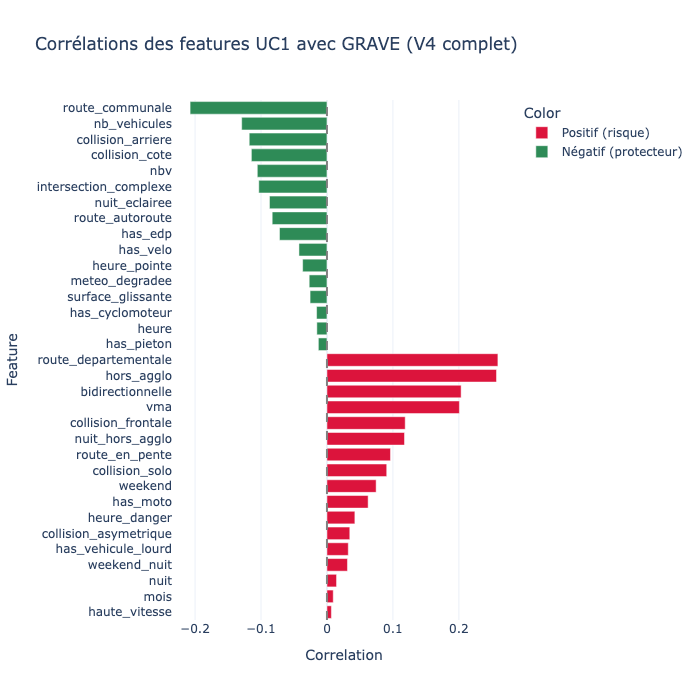

In [8]:
# Features disponibles en V4 (toutes)
v4_corr = all_correlations['v4_collision']

# Créer un DataFrame pour visualisation
df_corr = pd.DataFrame(v4_corr, columns=['Feature', 'Correlation'])
df_corr['Abs_Corr'] = df_corr['Correlation'].abs()
df_corr = df_corr.sort_values('Abs_Corr', ascending=True)

# Colorer selon positif/négatif
df_corr['Color'] = df_corr['Correlation'].apply(lambda x: 'Positif (risque)' if x > 0 else 'Négatif (protecteur)')

fig = px.bar(
    df_corr,
    x='Correlation',
    y='Feature',
    orientation='h',
    color='Color',
    color_discrete_map={'Positif (risque)': 'crimson', 'Négatif (protecteur)': 'seagreen'},
    title='Corrélations des features UC1 avec GRAVE (V4 complet)',
)

fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.update_layout(height=700, showlegend=True)
fig.show()

---
## 5. Analyse de l'apport marginal de chaque version

### Observation : Apport marginal par version

Le passage V1 -> V2 apporte le plus de pouvoir prédictif (+0.259 avec route_departementale). Les features route/agglomération dominent.

V2 -> V3 (véhicules) : apport modéré. nb_vehicules (-0.129) est le plus utile — plus il y a de véhicules, moins c'est grave (accidents multiples = souvent légers).

V3 -> V4 (collision) : 4 features avec des corrélations comparables (~0.1). collision_frontale (+0.119) confirme le risque du choc frontal.

Implication opérationnelle :
- La question "Etes-vous en ville ou sur route ?" reste prioritaire
- La question "Y a-t-il un poids lourd ?" est secondaire mais importante pour la mortalité

In [9]:
print("ANALYSE DE L'APPORT MARGINAL PAR VERSION\n")

# V1 → V2
print("--- V1 -> V2 : Apport de l'identification de la route ---")
v2_only = [f for f in features_v2 if f not in features_v1]
v2_corrs = [(f, df[f].corr(df[target])) for f in v2_only if df[f].dtype != 'object']
v2_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
print(f"Features ajoutées: {len(v2_only)}")
for feat, corr in v2_corrs:
    print(f"  {feat}: {corr:+.3f}")

# V2 → V3
print("\n--- V2 -> V3 : Apport des infos véhicules ---")
v3_only = [f for f in features_v3 if f not in features_v2]
v3_corrs = [(f, df[f].corr(df[target])) for f in v3_only if df[f].dtype != 'object']
v3_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
print(f"Features ajoutées: {len(v3_only)}")
for feat, corr in v3_corrs:
    print(f"  {feat}: {corr:+.3f}")

# V3 → V4
print("\n--- V3 -> V4 : Apport des infos collision ---")
v4_only = [f for f in features_v4 if f not in features_v3]
v4_corrs = [(f, df[f].corr(df[target])) for f in v4_only if df[f].dtype != 'object']
v4_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
print(f"Features ajoutées: {len(v4_only)}")
for feat, corr in v4_corrs:
    print(f"  {feat}: {corr:+.3f}")

ANALYSE DE L'APPORT MARGINAL PAR VERSION

--- V1 -> V2 : Apport de l'identification de la route ---
Features ajoutées: 14
  route_departementale: +0.259
  hors_agglo: +0.257
  route_communale: -0.208
  bidirectionnelle: +0.203
  vma: +0.201
  nuit_hors_agglo: +0.118
  nbv: -0.106
  intersection_complexe: -0.103
  route_en_pente: +0.096
  route_autoroute: -0.083
  weekend_nuit: +0.031
  meteo_degradee: -0.027
  surface_glissante: -0.026
  haute_vitesse: +0.007

--- V2 -> V3 : Apport des infos véhicules ---
Features ajoutées: 8
  nb_vehicules: -0.129
  has_edp: -0.072
  has_moto: +0.062
  has_velo: -0.042
  collision_asymetrique: +0.035
  has_vehicule_lourd: +0.032
  has_cyclomoteur: -0.016
  has_pieton: -0.013

--- V3 -> V4 : Apport des infos collision ---
Features ajoutées: 4
  collision_frontale: +0.119
  collision_arriere: -0.118
  collision_cote: -0.115
  collision_solo: +0.091


### Observation : Qualité des data

Aucune valeur manquante dans les 4 datasets.

Cela confirme que :
1. Le nettoyage en Phase 1-2 était efficace
2. L'exclusion de larrout (75% missing) était justifiée
3. Les datasets sont prêts pour la modélisation sans imputation

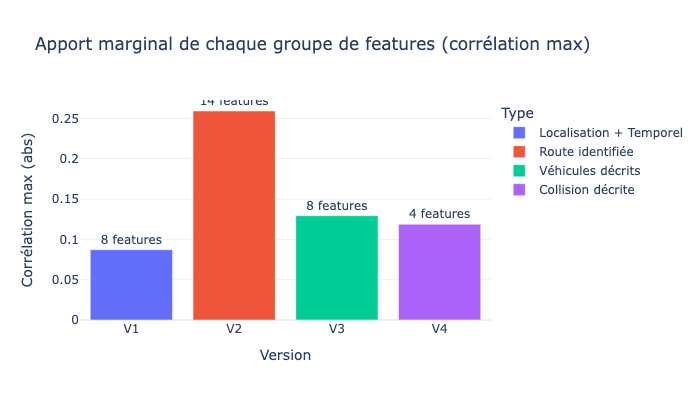

In [10]:
# Visualisation de l'apport par niveau
apport_data = []

# features numériques seulement (dep est catégoriel)
v1_num = [f for f in features_v1 if df[f].dtype != 'object']

v1_max = max(abs(df[f].corr(df[target])) for f in v1_num)
apport_data.append({'Version': 'V1', 'Type': 'Localisation + Temporel', 'Max_Corr': v1_max, 'Nb_Features': len(features_v1)})

v2_only_num = [f for f in v2_only if df[f].dtype != 'object']
v2_only_max = max(abs(df[f].corr(df[target])) for f in v2_only_num) if v2_only_num else 0
apport_data.append({'Version': 'V2', 'Type': 'Route identifiée', 'Max_Corr': v2_only_max, 'Nb_Features': len(v2_only)})

v3_only_num = [f for f in v3_only if df[f].dtype != 'object']
v3_only_max = max(abs(df[f].corr(df[target])) for f in v3_only_num) if v3_only_num else 0
apport_data.append({'Version': 'V3', 'Type': 'Véhicules décrits', 'Max_Corr': v3_only_max, 'Nb_Features': len(v3_only)})

v4_only_num = [f for f in v4_only if df[f].dtype != 'object']
v4_only_max = max(abs(df[f].corr(df[target])) for f in v4_only_num) if v4_only_num else 0
apport_data.append({'Version': 'V4', 'Type': 'Collision décrite', 'Max_Corr': v4_only_max, 'Nb_Features': len(v4_only)})

df_apport = pd.DataFrame(apport_data)

fig = px.bar(
    df_apport,
    x='Version',
    y='Max_Corr',
    color='Type',
    text='Nb_Features',
    title='Apport marginal de chaque groupe de features (corrélation max)',
    labels={'Max_Corr': 'Corrélation max (abs)', 'Nb_Features': 'Nb features'}
)

fig.update_traces(texttemplate='%{text} features', textposition='outside')
fig.update_layout(height=400)
fig.show()

---
## 6. Vérification des valeurs manquantes

In [11]:
print("VALEURS MANQUANTES PAR DATASET\n")

for name, df_v in created_datasets.items():
    missing = df_v.isnull().sum()
    total_missing = missing.sum()
    
    print(f"{name}: {total_missing} valeurs manquantes")
    
    if total_missing > 0:
        missing_cols = missing[missing > 0]
        for col, n in missing_cols.items():
            pct = n / len(df_v) * 100
            print(f"  - {col}: {n} ({pct:.1f}%)")
    else:
        print("  Aucune valeur manquante")

VALEURS MANQUANTES PAR DATASET

v1_base: 0 valeurs manquantes
  Aucune valeur manquante
v2_route: 0 valeurs manquantes
  Aucune valeur manquante
v3_vehicules: 0 valeurs manquantes
  Aucune valeur manquante
v4_collision: 0 valeurs manquantes
  Aucune valeur manquante


---
## 7. Résumé et recommandations

In [12]:
print("RÉSUMÉ UC1 - AIDE AUX SECOURS (v2)\n")

n_grave = df['grave'].sum()
pct_grave = df['grave'].mean() * 100
ratio_grave = (1 - df['grave'].mean()) / df['grave'].mean()

print(f"Target: GRAVE ({n_grave} cas, {pct_grave:.1f}%)")
print(f"Ratio classe: 1:{ratio_grave:.1f} - class_weight='balanced' suffisant")

print("\nDatasets créés (v2):")
print(f"  - UC1_v1_base.csv      : {len(features_v1)} features (département + temporel)")
print(f"  - UC1_v2_route.csv     : {len(features_v2)} features (+ route + météo/surface)")
print(f"  - UC1_v3_vehicules.csv : {len(features_v3)} features (+ véhicules décrits)")
print(f"  - UC1_v4_collision.csv : {len(features_v4)} features (+ type collision)")
print("  + Chaque dataset contient: Num_Acc, annee, target")

print("\nChangements v2:")
print("  dep au lieu de lat/long (granularité adaptée)")
print("  annee conservé pour split temporel train 2021-2023 / test 2024")
print("  Nouvelles features météo/surface ajoutées")
print("  Features redondantes supprimées")

# Split temporel stats
if 'annee' in df.columns:
    n_train = len(df[df['annee'] <= 2023])
    n_test = len(df[df['annee'] == 2024])
    print("\nSplit temporel:")
    print(f"  Train (2021-2023): {n_train} accidents")
    print(f"  Test (2024): {n_test} accidents")

print("\nProchaine étape: Phase 4 - Modélisation avec split temporel")

RÉSUMÉ UC1 - AIDE AUX SECOURS (v2)

Target: GRAVE (73796 cas, 35.4%)
Ratio classe: 1:1.8 - class_weight='balanced' suffisant

Datasets créés (v2):
  - UC1_v1_base.csv      : 8 features (département + temporel)
  - UC1_v2_route.csv     : 22 features (+ route + météo/surface)
  - UC1_v3_vehicules.csv : 30 features (+ véhicules décrits)
  - UC1_v4_collision.csv : 34 features (+ type collision)
  + Chaque dataset contient: Num_Acc, annee, target

Changements v2:
  dep au lieu de lat/long (granularité adaptée)
  annee conservé pour split temporel train 2021-2023 / test 2024
  Nouvelles features météo/surface ajoutées
  Features redondantes supprimées

Split temporel:
  Train (2021-2023): 157561 accidents
  Test (2024): 51055 accidents

Prochaine étape: Phase 4 - Modélisation avec split temporel


---
## Récapitulatif

4 datasets créés, chacun correspondant à un niveau d'information lors de l'appel d'urgence :
- **V1** (8 features) : quand et où
- **V2** (22 features) : + caractéristiques de la route
- **V3** (30 features) : + véhicules impliqués
- **V4** (34 features) : + type de collision

Tous les datasets contiennent la colonne `annee` pour le split temporel et `Num_Acc` comme identifiant.

**Prochaine étape** → `05a_model_UC1_secours.ipynb` : entraînement des modèles CatBoost.

---
## Notes techniques

### Logique des versions progressives

La progression V1 -> V4 simule l'enrichissement de l'information au cours d'un appel d'urgence :

```
V1 : GPS + horloge (automatique)           -> dep, heure, mois, nuit, weekend...
  |
V2 : + identification route (GPS/carte)     -> vma, hors_agglo, meteo, surface...
  |
V3 : + description véhicules (appelant)     -> has_moto, has_vehicule_lourd...
  |
V4 : + description collision (appelant)     -> collision_frontale, collision_solo...
```

### Features v2 exclues vs v1

| Feature v1 | Raison exclusion v2 | Alternative |
|------------|---------------------|-------------|
| lat, long | Overfitting | dep |
| nuit_non_eclairee | Corr 0.875 avec nuit_hors_agglo | nuit_hors_agglo |
| has_vulnerable | Corr -0.001 avec target | Exclue |
| has_poids_lourd, has_bus | Redondants | has_vehicule_lourd |
| jour_semaine | Redondant avec weekend | weekend |
| route_nationale, route_rapide | Faible apport | Exclues |

### Fichiers générés

| Fichier | Dimensions | Usage |
|---------|------------|-------|
| UC1_v1_base.csv | 208,616 x 11 | Baseline minimal |
| UC1_v2_route.csv | 208,616 x 25 | Avec infos route |
| UC1_v3_vehicules.csv | 208,616 x 33 | + véhicules |
| UC1_v4_collision.csv | 208,616 x 37 | Complet |

Chaque fichier contient Num_Acc (identifiant), annee (pour split temporel) et grave (target).